In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'uterinetube_uterinetube_HCLAdultFallopiantube1'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/uterinetube_uterinetube_HCLAdultFallopiantube1/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultFallopiantube_1.CGCTTGCAACAAGAATTA,AdultFallopiantube_1.TATGTATAGAGAGAGGAG,AdultFallopiantube_1.ACGTTGGCAGGAGCAGGA,AdultFallopiantube_1.ACTTATAACGCCGCTCAA,AdultFallopiantube_1.AAGCGGTCGTAAGAGATC
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,1
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>
AdultFallopiantube_1.AAAACGAAAACGTATGTA,AdultFallopiantube,AdultFallopiantube,NA,normal,1,Female,52Y
AdultFallopiantube_1.AAAACGAAAGTTAGGACT,AdultFallopiantube,AdultFallopiantube,NA,normal,5,Female,52Y
AdultFallopiantube_1.AAAACGAAAGTTCATGAT,AdultFallopiantube,AdultFallopiantube,NA,normal,3,Female,52Y
AdultFallopiantube_1.AAAACGAACCTACAAAGT,AdultFallopiantube,AdultFallopiantube,NA,normal,2,Female,52Y
AdultFallopiantube_1.AAAACGAACGCCAGCGAG,AdultFallopiantube,AdultFallopiantube,NA,normal,1,Female,52Y


[1] "Stromal cell"               "Smooth muscle cell"        
[3] "Fibroblast"                 "Oviductal epithelial  cell"
[5] "Stromal cell"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


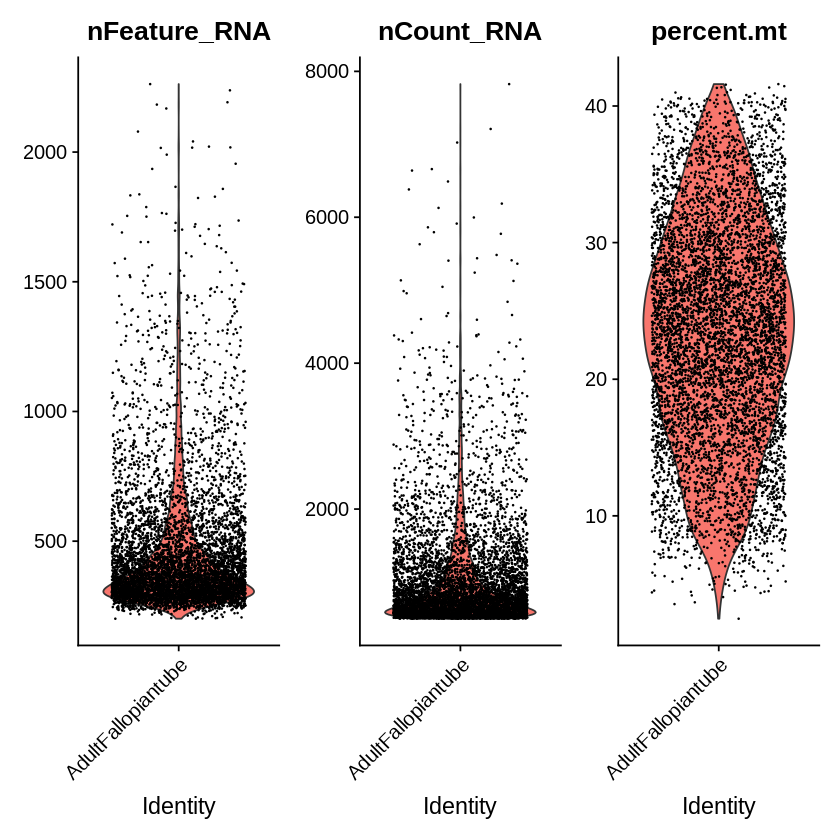

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [9]:
# QC
nFeature_RNA_range = c(200, 1000)
percent.mt.thre = 45
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  FAM183A, C20orf85, CAPS, C1orf194, TPPP3, RP11-356K23.1, AGR3, C11orf88, C9orf24, PIFO 
	   CAPSL, SNTN, CETN2, SCGB2A1, MORN2, CFAP126, MORN5, RSPH1, PSENEN, C9orf135 
	   C9orf116, DYNLRB2, AGR2, RP4-666F24.3, SPA17, RIIAD1, NME5, DYDC2, SCGB1D4, FAM81B 
Negative:  FTL, SRGN, IL1B, GPR183, BCL2A1, FCER1G, TYROBP, AIF1, CCL3, PLEK 
	   C1QB, CCL3L3, RGS1, CCL4, CCL20, HLA-DPA1, G0S2, RGS2, HLA-DQA1, HLA-DPB1 
	   CD83, PLAUR, LAPTM5, CCL4L2, C1QA, MS4A6A, CD53, C15orf48, LST1, C1QC 
PC_ 2 
Positive:  MT-RNR2, MT-RNR1, DCN, MGP, APOD, LUM, ADIRF, DPT, CFD, IGFBP6 
	   PTGDS, MFAP4, GNG11, CTSK, PLAC9, CCL2, MYL9, TAGLN, IGFBP3, HSPA1A 
	   TCEAL7, TPM2, MT1A, SFRP2, CAV1, CXCL14, MFAP5, ACTA2, TFPI, EMP1 
Negative:  IL1B, GPR183, FCER1G, BCL2A1, TYROBP, HLA-DRA, HLA-DPA1, AIF1, HLA-DQA1, G0S2 
	   HLA-DRB1, CCL3, PLEK, C1QB, HLA-DPB1, RGS1, CCL20, CCL3L3, SRGN, HLA-DRB5 
	   CCL4, CD74, PLAUR, CD83, C15orf48, CXCL8, MS4A6A, C1QA, CCL4L2, C1QC 
PC_ 3 
Positive:  DCN, M

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


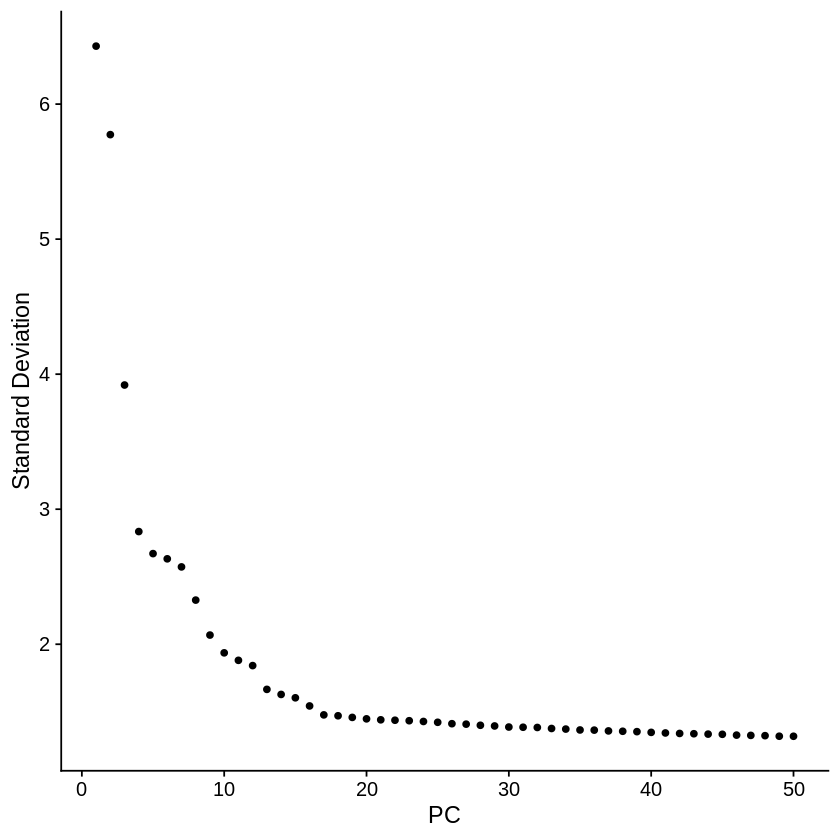

In [12]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [13]:
dev.off()
pcDim = 10 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:42:16 UMAP embedding parameters a = 0.9922 b = 1.112

17:42:16 Read 6238 rows and found 10 numeric columns

17:42:16 Using Annoy for neighbor search, n_neighbors = 30

17:42:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:42:16 Writing NN index file to temp file /tmp/Rtmpo9znXS/file26472d1d297d

17:42:16 Searching Annoy index using 1 thread, search_k = 3000

17:42:18 Annoy recall = 100%

17:42:19 Commencing smooth kNN distance calibration using 1 thread

17:42:19 Initializing fro

In [18]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.7)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6238
Number of edges: 209767

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8883
Number of communities: 13
Elapsed time: 0 seconds


17:44:02 UMAP embedding parameters a = 0.9922 b = 1.112

17:44:02 Read 6238 rows and found 10 numeric columns

17:44:02 Using Annoy for neighbor search, n_neighbors = 30

17:44:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:44:03 Writing NN index file to temp file /tmp/Rtmpo9znXS/file2647485795b9

17:44:03 Searching Annoy index using 1 thread, search_k = 3000

17:44:05 Annoy recall = 100%

17:44:05 Commencing smooth kNN distance calibration using 1 thread

17:44:06 Initializing from normalized Laplacian + noise

17:44:06 Commencing optimization for 500 epochs, with 273384 positive edges

17:44:21 Optimization finished



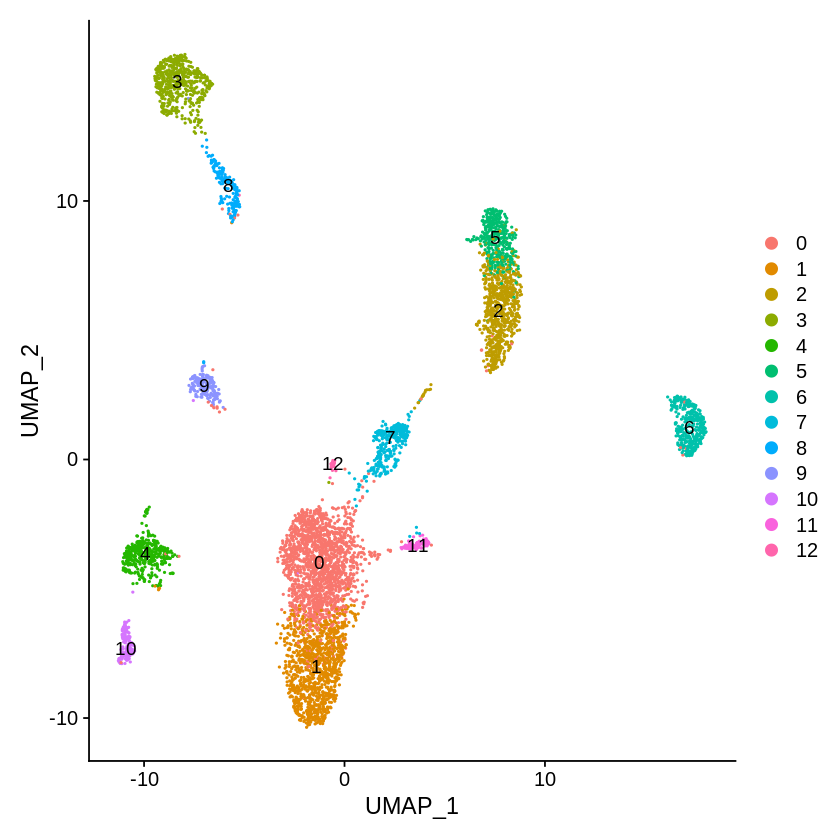

In [19]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [20]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

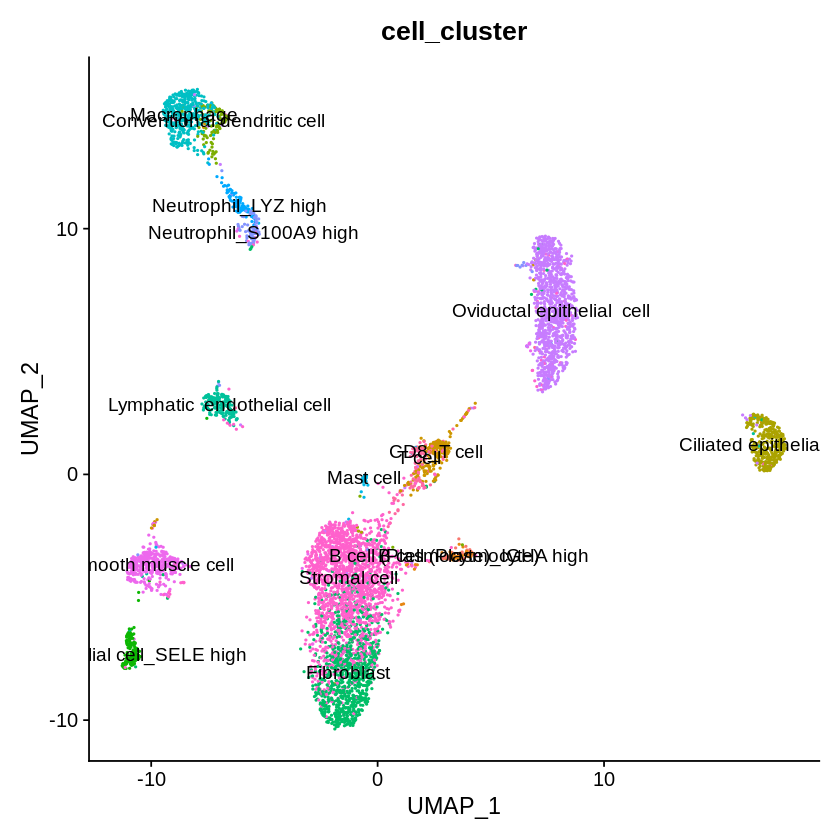

In [21]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [22]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [23]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [25]:
new.cluster.ids <- c("Uterinetube-Connective tissue-Stromal cell-DCN",
                     "Uterinetube-Connective tissue-Fibroblast-DCN FBLN1",
                     "Uterinetube-Epithelial tissue-Epithelial cell-OVGP1 CRISP3 KRT18",
                     "Uterinetube-Connective tissue-Macrophage-IL1B CD74 CCL3",
                     "Uterinetube-Muscle tissue-Smooth muscle cell-TAGLN MYL9 MYH11",
                     "Uterinetube-Epithelial tissue-Epithelial cell-KRT18 OVGP1",
                     "Uterinetube-Epithelial tissue-Epithelial cell-SCGB1D4 AGR3",
                     "Uterinetube-Connective tissue-T cell/CD8_T cell-IL32 PTPRC",
                     "Uterinetube-Connective tissue-Neutrophilic granulocyte-FCN1 S100A12",
                     "Uterinetube-Epithelial tissue-Endothelial cell-MMRN1 LYVE1",
                     "Uterinetube-Epithelial tissue-Endothelial cell-SELE",
                     "Uterinetube-Connective tissue-B cell-MZB1 CD79A",
                     "Uterinetube-Connective tissue-Mast cell-TPSB2 TPSAB1 CD44"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [26]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [27]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

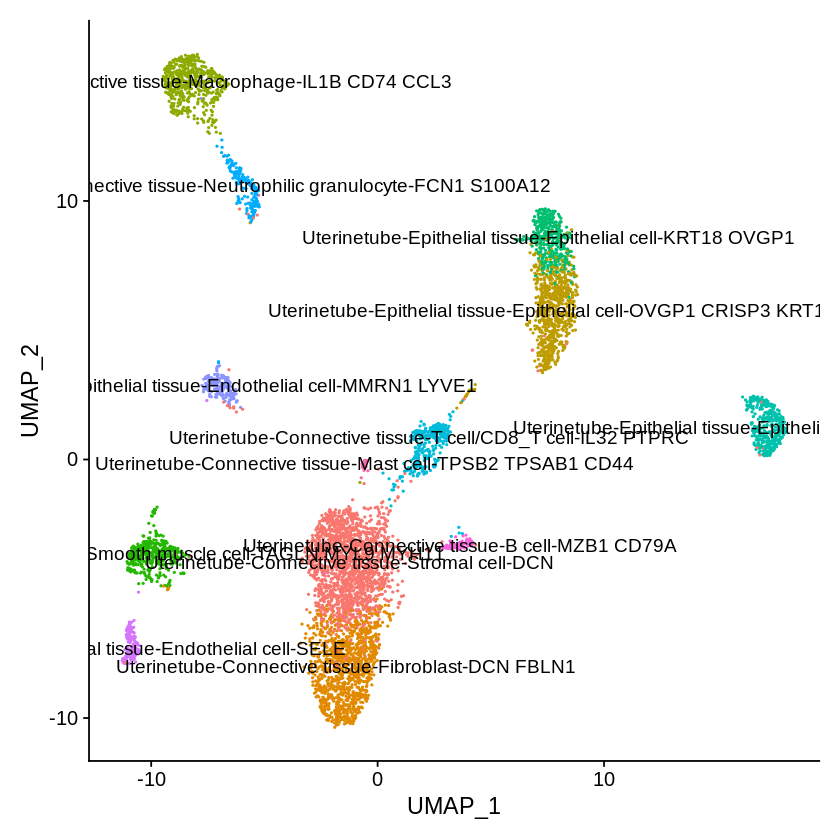

In [28]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [79]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))